In [1]:
import jax
import numpy as np
import jax.numpy as jnp
import time
import optax
import matplotlib.pyplot as plt 
from jax.flatten_util import ravel_pytree
from functools import partial
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import piml_library.lagrangian as lag
import piml_library.hamiltonian as ham
import piml_library.util as util
import piml_library.early_stopping as es
import piml_library.plotting as plotting
from piml_library.bnn_h import (
    BaselineNN_h, 
    compute_loss, 
    train_step, 
    create_trajectory,
)
import dataset_generator as dg

In [2]:
@jax.jit
#L((t, q, v))
def L_analytical(state):
    q = lag.coordinate(state)
    v = lag.velocity(state)
    q_flat, _ = ravel_pytree(q)
    v_flat, _ = ravel_pytree(v)
    
    T = 0.5 * jnp.sum(v_flat**2)
    V = 0.5 * jnp.sum(q_flat**2)
    return T - V

In [3]:
@jax.jit
#H((t, q, p))
def H_analytical(state, m=1.0, k=1.0):
    q = ham.coordinate(state) 
    p = ham.momentum(state) 
    
    q_flat, _ = ravel_pytree(q) 
    p_flat, _ = ravel_pytree(p) 
    
    T = 0.5 / m * jnp.sum(p_flat**2) 
    V = 0.5 * k * jnp.sum(q_flat**2) 
    return T + V 

In [4]:
q_dim = 1
hidden_dim = 200
learning_rate = 1e-2
num_epochs = 10000
key = jax.random.PRNGKey(8)

'''
HNNpaperでは25軌道、30点
'''
num_trajectories = 100
N_points_per_traj = 30
t_end = 3.0
t_eval = jnp.linspace(0.0, t_end, N_points_per_traj)

split_ratio = 0.5
N_points_train = int(N_points_per_traj * split_ratio)

--- 学習用・テスト用データセットの生成開始 ---
Generating 100 trajectories...
--- データセット生成完了 ---
Total Train Points: 1500
Total Test Points:  1500


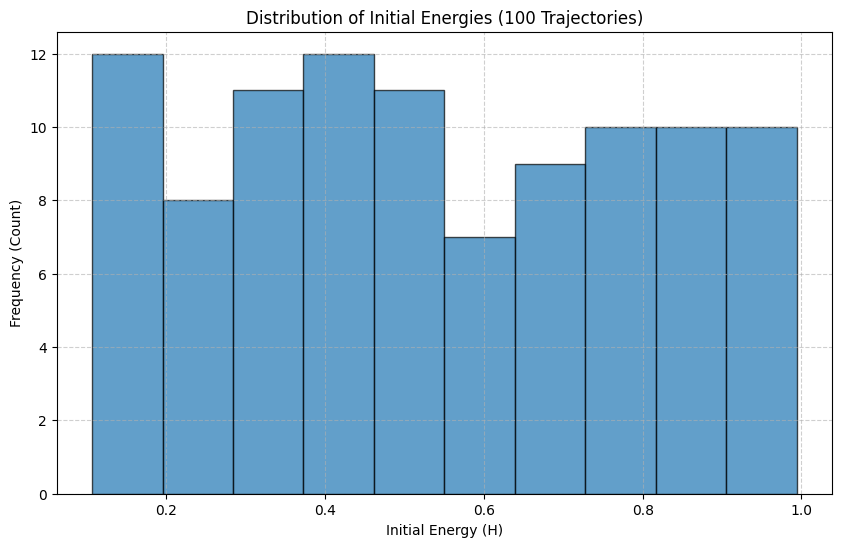

In [5]:
data_dict = dg.create_trajectory_datasets(
    L_analytical, 
    H_analytical,
    key,
    q_dim=q_dim,
    num_trajectories=num_trajectories,
    N_points_per_traj=N_points_per_traj,
    t_end=t_end,
    split_ratio=split_ratio
)

train_states = data_dict["train_states_hnn"]
train_t, train_q, train_p = train_states
train_targets = data_dict["train_targets_hnn"]
test_dataset_states = data_dict["test_dataset_states_hnn"]
test_dataset_targets = data_dict["test_dataset_targets_hnn"]
initial_energies = data_dict["initial_energies"]
N_train_total = data_dict["N_train_total"]

key, _ = jax.random.split(key) 

# --- エネルギー分布の可視化 ---
energies_np = np.array(initial_energies)

plt.figure(figsize=(10, 6))
plt.hist(energies_np, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Initial Energy (H)')
plt.ylabel('Frequency (Count)')
plt.title(f'Distribution of Initial Energies ({num_trajectories} Trajectories)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



In [6]:
'''
learning Process
'''

# --- モデルとオプティマイザの初期化 ---
bnn_model = BaselineNN_h(hidden_dim=hidden_dim, output_dim=q_dim)
model_apply_fn = bnn_model.apply  # jitで使用できるようにするためapplyというメソッドを変数に割り当てる。

key, init_key = jax.random.split(key) #同じkeyを与えると同じ値を毎回与える

# モデルを初期化するためのダミー入力 (t, q, v)
# q と v は q_dim に合わせる
dummy_q = jnp.zeros((q_dim,))
dummy_p = jnp.zeros((q_dim,))
dummy_state = (0.0, dummy_q, dummy_p)

params = bnn_model.init(init_key, dummy_state)['params'] #構造を決定
optimizer = optax.adamw(learning_rate, weight_decay=1e-4)
opt_state = optimizer.init(params) #重みを追跡するために必要な内部メモリ状態

es = es.EarlyStopping(patience=100, verbose=True, path='best_lnn_params.pkl', mode='min', save_best_on_disk=False)

print("モデルとオプティマイザの初期化完了。学習を開始します...")

start_train_time = time.time()

'''
全バッチ学習に変更する
'''
# ミニバッチのサイズ
batch_size = 256 

# --- 学習ループ ---
for epoch in range(num_epochs):
    
    '''
    # randomly choose trajectory 
    key, data_key = jax.random.split(key)
    indices = jax.random.choice(data_key, N_train_total, shape=(batch_size,), replace=False)
    
    # make mini batch
    t_batch = train_t[indices]
    q_batch = train_q[indices]
    p_batch = train_p[indices]
    
    #batch_states = (t_batch, q_batch, p_batch)
    #batch_true_targets = train_targets[indices]
    '''
    
    params, opt_state, train_loss = train_step(
        params, 
        opt_state, 
        optimizer, 
        model_apply_fn, 
        train_states, 
        train_targets  
    )
    
    check_interval = 10
    
    if epoch % check_interval == 0:
        test_loss = compute_loss(
            params,
            model_apply_fn,
            test_dataset_states,
            test_dataset_targets
        )
        
        if epoch % 100 == 0:
             print(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        es(test_loss, params)
        if es.early_stop:
            print(f"Early stopping triggered at epoch {epoch}")
            break

print("学習完了。")
final_params = es.best_params

# Final Test Loss
final_test_loss = compute_loss(final_params, model_apply_fn, test_dataset_states, test_dataset_targets)
final_test_loss.block_until_ready()
end_train_time = time.time()
print(f"--- Final Test Loss: {final_test_loss:.6f} ---")
print(f"--- Total Training Time: {end_train_time - start_train_time:.2f} seconds ---")

モデルとオプティマイザの初期化完了。学習を開始します...
Epoch 0, Train Loss: 0.900137, Test Loss: 38.154087
Validation metric set to 38.154087.  Saving model ...
Validation metric improved from 38.154087 to 0.158331.  Saving model ...
EarlyStopping counter: 1 out of 100
Validation metric improved from 0.158331 to 0.156131.  Saving model ...
Validation metric improved from 0.156131 to 0.137854.  Saving model ...
Validation metric improved from 0.137854 to 0.122078.  Saving model ...
Validation metric improved from 0.122078 to 0.111043.  Saving model ...
Validation metric improved from 0.111043 to 0.101626.  Saving model ...
Validation metric improved from 0.101626 to 0.093297.  Saving model ...
Validation metric improved from 0.093297 to 0.085413.  Saving model ...
Epoch 100, Train Loss: 0.081033, Test Loss: 0.078617
Validation metric improved from 0.085413 to 0.078617.  Saving model ...
Validation metric improved from 0.078617 to 0.073201.  Saving model ...
Validation metric improved from 0.073201 to 0.068082. 

In [7]:
'''
generate trajectory
'''

# 予測と正解データ(自動微分による計算)での比較
print("軌道を生成して、真の挙動と比較します...")
#based on BNN_h
ds_true = ham.state_derivative(H_analytical)
solver_true = util.ode_solver(ds_true)

solver_learned = create_trajectory(model_apply_fn, final_params, q_dim)

# s0 = (t, q, p)
initial_state = (0.0, jnp.array([1.0]), jnp.array([0.0]))
t_eval = jnp.linspace(0.0, 100.0, 10000) 

ham_to_lgr_state_fn = ham.hamiltonian_state_to_lagrangian_state(H_analytical)

ham_states_true = solver_true(initial_state, t_eval)
lgr_states_true = jax.vmap(ham_to_lgr_state_fn)(ham_states_true)

ham_states_learned = solver_learned(initial_state, t_eval)
lgr_states_learned = jax.vmap(ham_to_lgr_state_fn)(ham_states_learned)

start_inference_time = time.time()
lgr_states_learned[1].block_until_ready() 
end_inference_time = time.time()
print(f"--- Trajectory Inference Time: {end_inference_time - start_inference_time:.4f} seconds ---")

print("軌道生成が完了しました。")

軌道を生成して、真の挙動と比較します...
--- Trajectory Inference Time: 0.0521 seconds ---
軌道生成が完了しました。


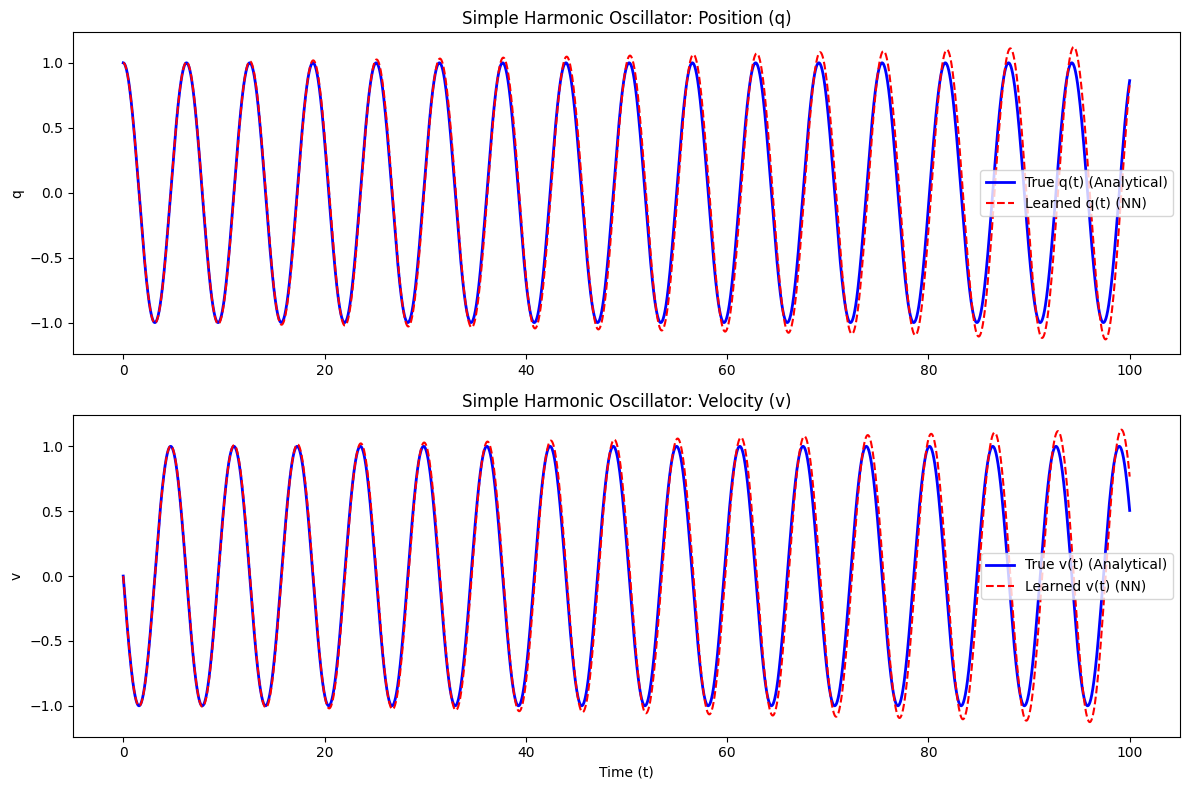

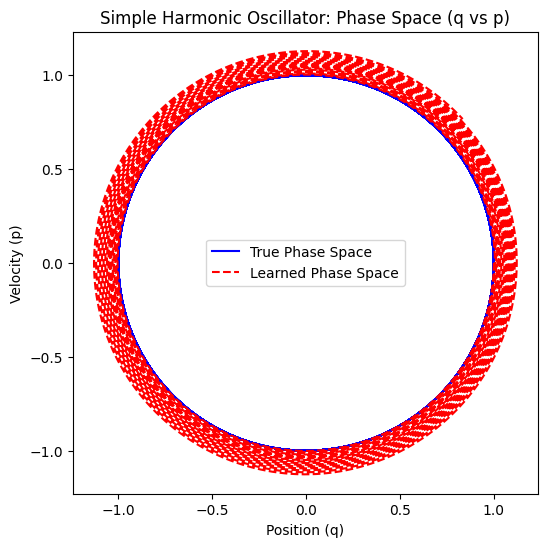

In [8]:
''' 
plot result
'''
t_true, q_true, p_true = ham_states_true
v_true = lgr_states_true[2]
t_learned, q_learned, p_learned = ham_states_learned
v_learned = lgr_states_learned[2]

title_prefix="Simple Harmonic Oscillator:"
plotting.plot_trajectory_comparison(
    t_true, q_true, v_true, 
    t_learned, q_learned, v_learned,
    title_prefix
)

plotting.plot_phase_space(
    q_true, p_true, 
    q_learned, p_learned,
    title_prefix
    )

In [9]:
np.savez(
    "results_H1D_NN_h.npz", 
    t_learned_nn_h=np.array(t_learned),
    q_learned_nn_h=np.array(q_learned),
    v_learned_nn_h=np.array(v_learned),
    p_learned_nn_h=np.array(p_learned),
    t_true=np.array(t_true),
    q_true=np.array(q_true),
    v_true=np.array(v_true),
    p_true=np.array(p_true)
)